In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

In [7]:
train_start_date = '2016-01-01'
train_end_date = '2022-12-31'
predict_start_date = '2023-01-01'
predict_end_date = '2023-12-31'

btc = yf.download('BTC-USD', start=train_start_date, end=predict_end_date)
print(btc.head())

[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2016-01-01  430.721008  436.246002  427.515015  434.334015  434.334015   
2016-01-02  434.622009  436.062012  431.869995  433.437988  433.437988   
2016-01-03  433.578003  433.743011  424.705994  430.010986  430.010986   
2016-01-04  430.061005  434.516998  429.084015  433.091003  433.091003   
2016-01-05  433.069000  434.182007  429.675995  431.959991  431.959991   

              Volume  
Date                  
2016-01-01  36278900  
2016-01-02  30096600  
2016-01-03  39633800  
2016-01-04  38477500  
2016-01-05  34522600  


In [8]:
# Wyodrębnij dane do treningu i testowania na podstawie dat
date = pd.to_datetime(predict_start_date)
new_date = date - pd.Timedelta(days=100)
train_data = btc.loc[train_start_date:train_end_date]['Close'].values.reshape(-1, 1)
test_data = btc.loc[new_date.strftime('%Y-%m-%d'):predict_end_date]['Close'].values.reshape(-1, 1)
print(len(train_data), len(test_data))

print(btc.loc[predict_start_date:predict_end_date])

2557 464
                    Open          High           Low         Close  \
Date                                                                 
2023-01-01  16547.914062  16630.439453  16521.234375  16625.080078   
2023-01-02  16625.509766  16759.343750  16572.228516  16688.470703   
2023-01-03  16688.847656  16760.447266  16622.371094  16679.857422   
2023-01-04  16680.205078  16964.585938  16667.763672  16863.238281   
2023-01-05  16863.472656  16884.021484  16790.283203  16836.736328   
...                  ...           ...           ...           ...   
2023-12-26  43599.847656  43603.175781  41676.488281  42520.402344   
2023-12-27  42518.468750  43683.160156  42167.582031  43442.855469   
2023-12-28  43468.199219  43804.781250  42318.550781  42627.855469   
2023-12-29  42614.644531  43124.324219  41424.062500  42099.402344   
2023-12-30  42091.753906  42584.125000  41556.226562  42156.902344   

               Adj Close       Volume  
Date                                   


In [9]:
# 3. Normalizacja danych
scaler = MinMaxScaler(feature_range=(0, 1))
print(type(scaler))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)
print(len(train_data_scaled), len(test_data_scaled))

<class 'sklearn.preprocessing._data.MinMaxScaler'>
2557 464


In [10]:
# 4. Podział danych na zestawy treningowe i testowe
# train_size = int(len(btc_close_scaled) * 0.8)  # 80% danych do treningu
# train_data, test_data = btc_close_scaled[0:train_size], btc_close_scaled[train_size:len(btc_close_scaled)]
# print(train_size)
# print(len(btc_close_scaled))


In [11]:
# 5. Przygotowanie danych do LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
time_step = 100
X_train, y_train = create_dataset(train_data_scaled, time_step)
X_test, y_test = create_dataset(test_data_scaled, time_step)


In [13]:
# 6. Konwersja danych do formatu akceptowanego przez LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(len(X_train), len(X_test))

2456 363


In [14]:
# 7. Tworzenie modelu LSTM
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(100, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])
model.summary()

C:\Users\Michał\Desktop\crypto\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,751 (483.40 KB)

 Trainable params: 123,751 (483.40 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Kompilacja modelu
model.compile(optimizer='adam', loss='mean_squared_error')

# 8. Trenowanie modelu
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=64, verbose=1)

Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.0176 - val_loss: 0.0012
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 9.8296e-04 - val_loss: 7.0186e-04
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 7.3583e-04 - val_loss: 4.5452e-04
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 6.8038e-04 - val_loss: 6.1695e-04
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 7.5706e-04 - val_loss: 6.9173e-04
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 7.2220e-04 - val_loss: 3.4940e-04
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 5.9178e-04 - val_loss: 4.2304e-04
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 6.8146e-04 - val_loss: 3.6956e-04
Epoch 9/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 4.8743e-04 - val_loss: 3.7040e-04
Epoch 10/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 4.7420e-04 - val_loss: 6.2744e-04
Epoch 11/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 5.2275e-04 - v

In [16]:
# 9. Predykcja na danych testowych
predictions = model.predict(X_test)
print(predictions[:10])

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
[[0.24785668]
 [0.24770547]
 [0.24809632]
 [0.24855958]
 [0.24972808]
 [0.25072291]
 [0.25187534]
 [0.25276408]
 [0.2538797 ]
 [0.25520375]]


In [17]:
# 10. Odwrotna transformacja dla porównania z rzeczywistymi danymi
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
print(y_test[:10])

[[16625.08007812]
 [16688.47070312]
 [16679.85742188]
 [16863.23828125]
 [16836.73632812]
 [16951.96875   ]
 [16955.078125  ]
 [17091.14453125]
 [17196.5546875 ]
 [17446.29296875]]


In [18]:
print(len(predictions))
print(len(X_test))

363
363


363
364


ConversionError: Failed to convert value(s) to axis units: '2023-01-01'

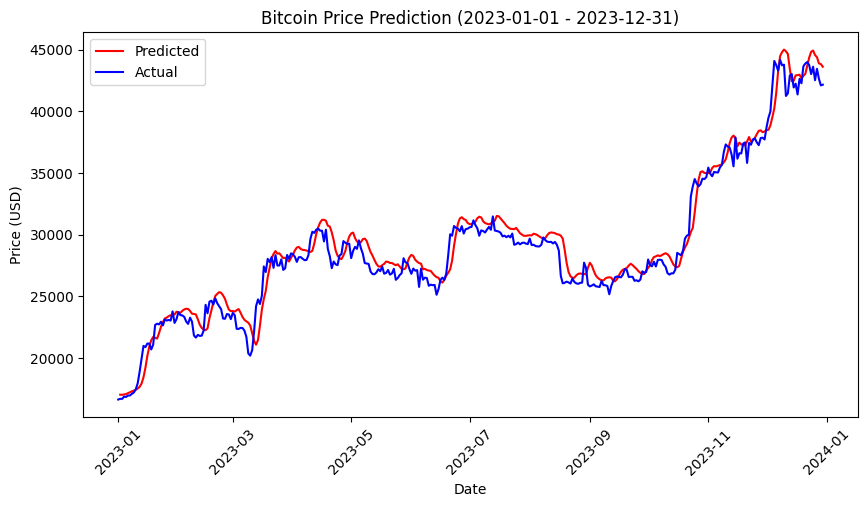

In [19]:
# Wizualizacja prognozy i rzeczywistych danych dla roku 2023
plt.figure(figsize=(10, 5))

# Daty testowe (dla prognoz)
test_dates = btc.loc[new_date.strftime('%Y-%m-%d'):predict_end_date].index[time_step + 1:len(predictions) + time_step + 1]
print(len(test_dates))
# Wykres przewidywań
plt.plot(test_dates, predictions, label='Predicted', color='red')

# Wyświetlanie rzeczywistych cen dla tego okresu
actual_prices = btc['Close'].loc[predict_start_date:predict_end_date]
actual_dates = actual_prices.index
print(len(actual_dates))
plt.plot(actual_dates, actual_prices, label='Actual', color='blue')

plt.title(f'Bitcoin Price Prediction ({predict_start_date} - {predict_end_date})')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.xlim([predict_start_date, predict_end_date])  # Ustawiamy zakres osi X
plt.show()

print(predictions)
